![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.7.Generative_AI_to_Ner_Training.ipynb)

# 🧨 **Colab Setup**

In [ ]:
import json
import os

from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.4.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [ ]:
import json
import os

import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp_jsl.pipeline_tracer import PipelineTracer
from sparknlp_jsl.pipeline_output_parser import PipelineOutputParser

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel

import pandas as pd
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark = sparknlp_jsl.start(license_keys['SECRET'])

spark

# 🎇 **BASE PIPELINE**

In [ ]:
document_assembler = DocumentAssembler().setInputCol("text").setOutputCol("document")

sentence_detector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare", "en", "clinical/models") \
    .setInputCols(["document"]).setOutputCol("sentence")

tokenizer = Tokenizer().setInputCols(["sentence"]).setOutputCol("token")

embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"]).setOutputCol("embeddings")


text = """Dr. John Lee, from Royal Medical Clinic in Chicago,  attended to the patient on 11/05/2024.
The patient’s medical record number is 56467890. The patient, Emma Wilson, is 50 years old,  her Contact number: 444-456-7890 .
Dr. John Taylor, ID: 982345, a cardiologist at St. Mary's Hospital in Boston, was contacted on 05/10/2023 regarding a 45-year-old.
"""
base_pipeline = Pipeline().setStages([
    document_assembler,
    sentence_detector,
    tokenizer,
    embeddings
])
base_pipeline_model = base_pipeline.fit(spark.createDataFrame([[text]]).toDF("text"))
data = spark.createDataFrame([[text]]).toDF("text")

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


## 📌**JSON**

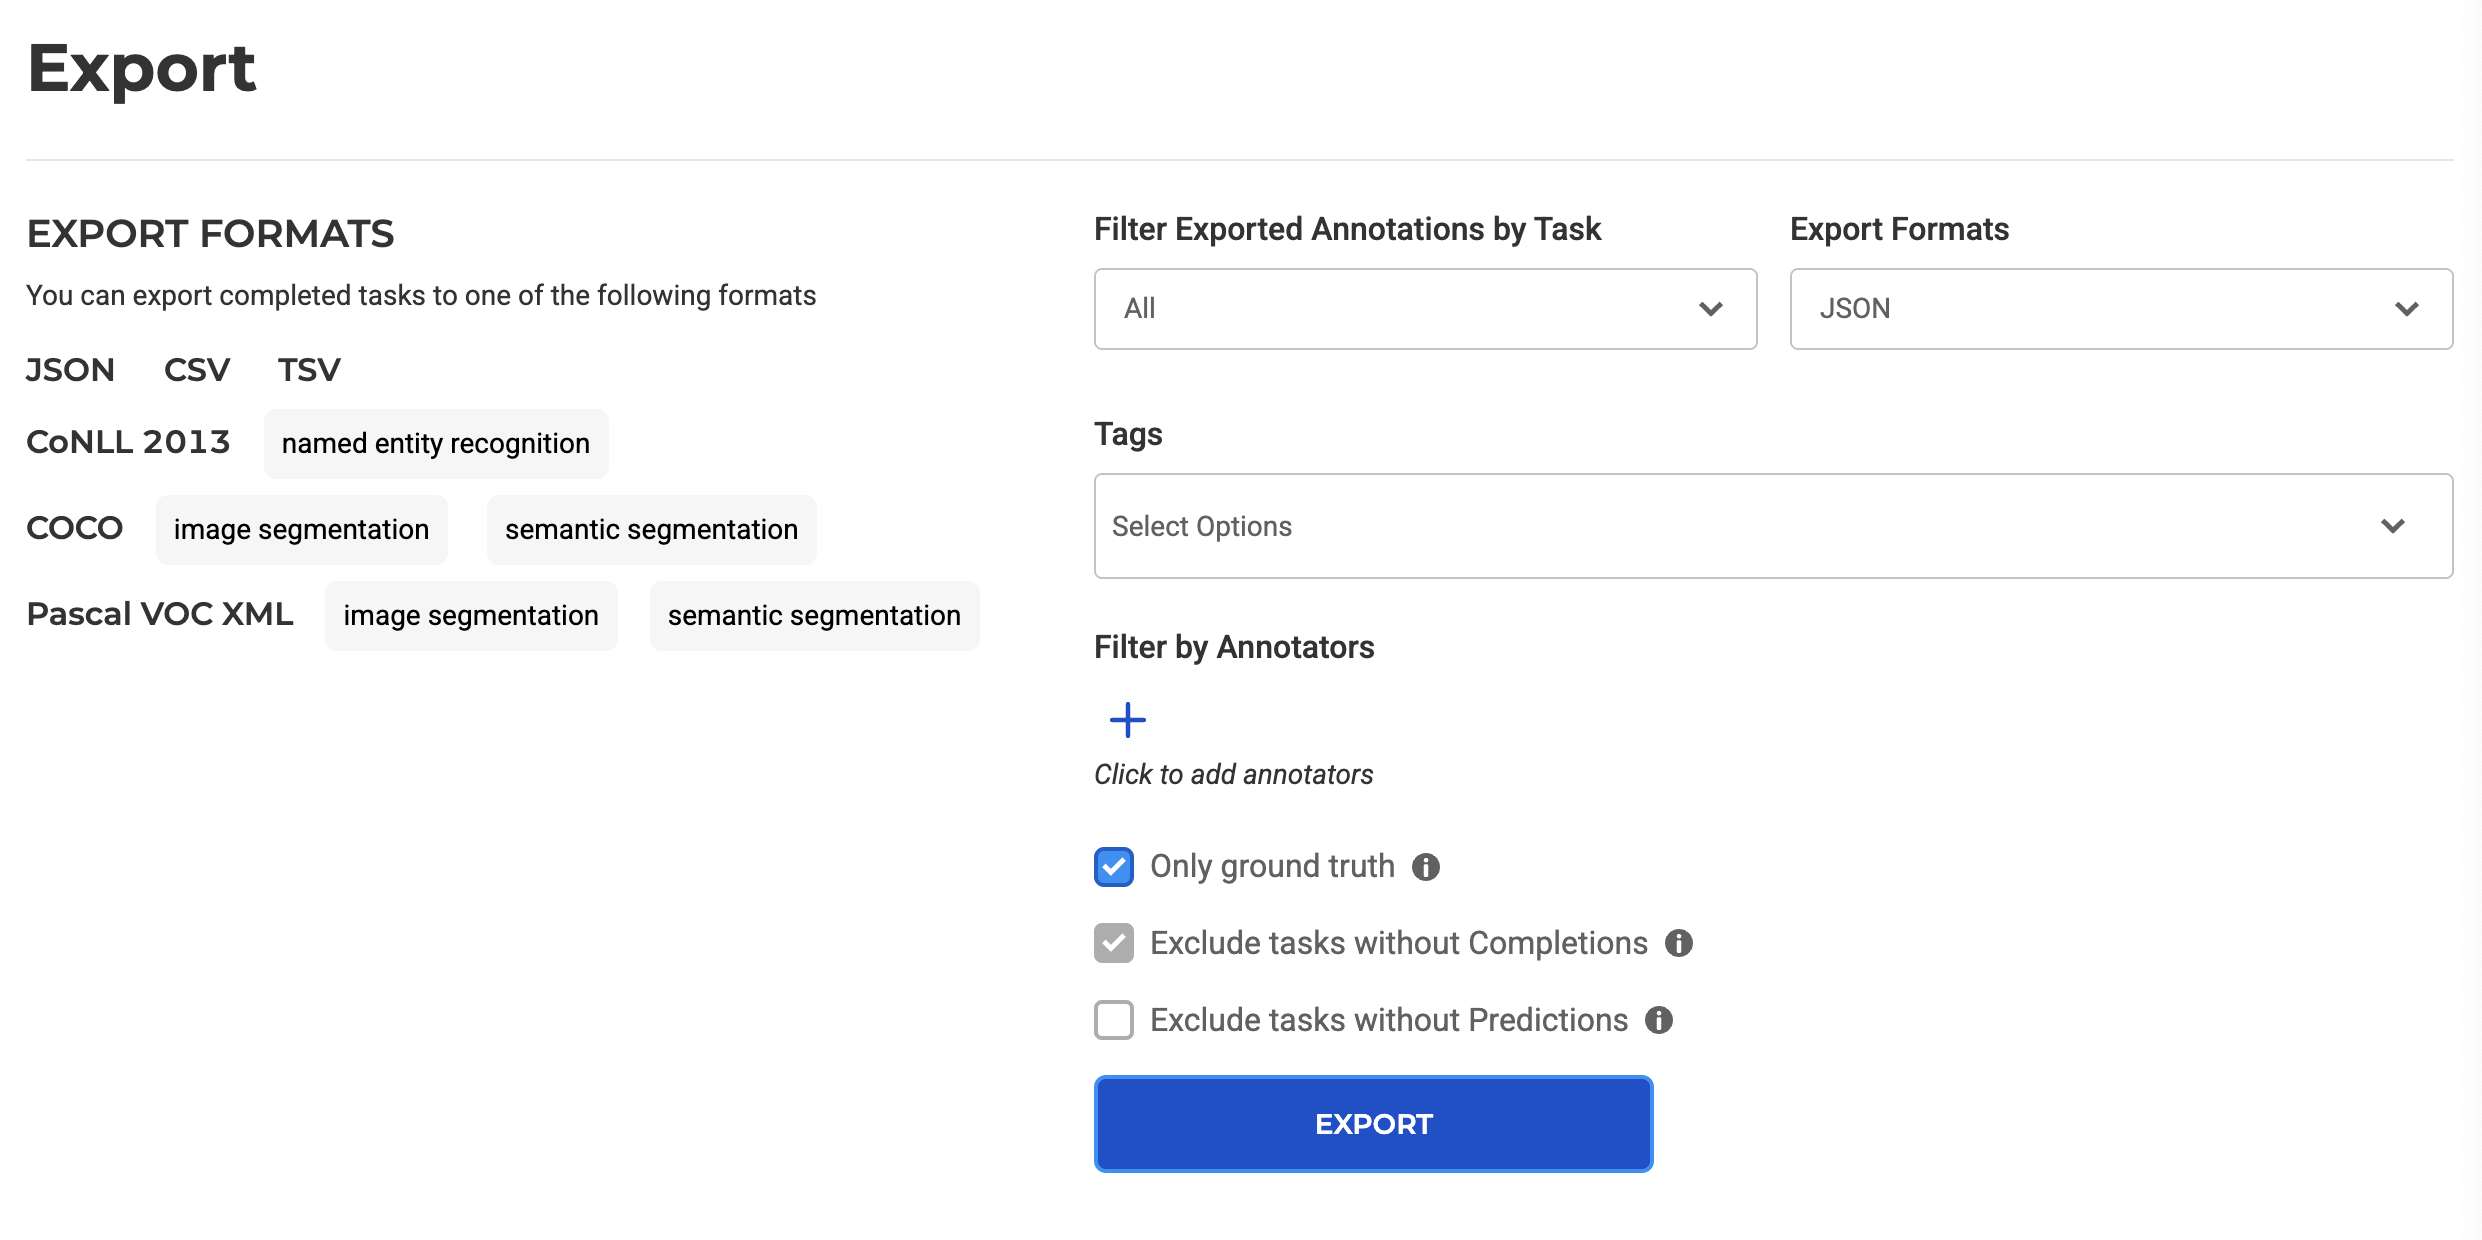

In [ ]:
JSON_PATH = "/content/result.json"

from sparknlp_jsl.training import Annotation2Training
annotation2training = Annotation2Training(spark)
training_df_json = annotation2training.convertJson2NerDF(
    json_path = JSON_PATH,                   # Path to the input JSON file.
    pipeline_model = base_pipeline_model,    # A pre-trained Spark NLP PipelineModel that includes at least a DocumentAssembler, and Tokenizer.
    repartition = (os.cpu_count() * 4),      # Number of partitions to use when creating the DataFrame (default is 32).
    token_output_col = "token",              # The name of the column containing token annotations (default is "token").
    ner_label_col = "label")                 # The name of the output column for NER labels (default is "label").

### 🎈 **Split training and Test DF**

In [ ]:
df_training, df_testing = training_df_json.randomSplit([0.8, 0.2], seed=42)

In [ ]:
%%time
training_df_json.write.mode("overwrite").parquet("/content/training_df_json")
df_testing.write.mode("overwrite").parquet("/content/df_testing")
df_training.write.mode("overwrite").parquet("/content/df_training")

CPU times: user 6.2 ms, sys: 963 µs, total: 7.16 ms
Wall time: 28.7 s


### 🎯 **Train a NER Model**

If you encounter an error when running MedicalNerDLGraphChecker, it means that There is no suitable graph in the jar. In such cases, you need to manually build the TF graph before using the annotator.

You can generate the TensorFlow graph with the TFGraphBuilder utility and then reload your NER model with the newly built graph.
For step-by-step instructions, please refer to the [Clinical Named Entity Recognition Model Notebook](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.Clinical_Named_Entity_Recognition_Model.ipynb#scrollTo=dPNI5AQ4W4oE), which demonstrates how to build and use custom graphs for MedicalNerApproach.

This approach ensures that the model is correctly initialized and prevents runtime errors related to missing or incompatible TensorFlow graphs.

In [ ]:
train_df_readed = spark.read.parquet("/content/df_training")

In [ ]:
nerDLGraphChecker = (MedicalNerDLGraphChecker()
            .setInputCols(["sentence", "token"])
            .setLabelColumn("label")
            .setEmbeddingsModel(embeddings))

If you encounter the following error when calling the `fit()` function:

*IllegalArgumentException: NerDLGraphChecker: requirement failed: Graph dimensions should be XXX: Could not find a suitable tensorflow graph for embeddings dim: YYY tags: ZZ nChars: WW.*

This means you need to create a compatible graph and provide its path to `MedicalNerApproach` using the `setGraphFolder()` function.

In [ ]:
nerDLGraphChecker.fit(train_df_readed)

If you don’t see any error, you’re ready to train your custom model!

In [ ]:
nerTagger = (MedicalNerApproach()
            .setInputCols(["sentence", "token", "embeddings"])
            .setLabelColumn("label")
            .setOutputCol("ner")
            .setRandomSeed(42)
            .setBatchSize(8)
            .setVerbose(1)
            .setLr(0.001)
            .setMaxEpochs(16)
            .setValidationSplit(0.2)
            .setIncludeConfidence(True)
            .setUseBestModel(True)
            #.setGraphFolder(graph_folder_path)
            )

In [ ]:
%%time
ner_model = nerTagger.fit(train_df_readed)

CPU times: user 138 ms, sys: 39.6 ms, total: 178 ms
Wall time: 15min 45s


### 📍**Save the NER model**

In [ ]:
ner_model.write().overwrite().save("/content/ner_model")

### 📍**NER Model Result with test df**

In [ ]:
test_df_readed = spark.read.parquet("/content/df_testing")
ner_model.transform(test_df_readed).write.mode("overwrite").parquet("/content/ner_model_result")

### 📍**Metrics**

In [ ]:
result_test_df = spark.read.parquet("/content/ner_model_result").repartition(os.cpu_count() * 4)
result_test_df.show(3)

+--------------------+--------------------+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|               title| id|            document|            sentence|               token|          embeddings|               label|                 ner|
+--------------------+--------------------+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|A 25-year-old fem...|sbir_iimd_second_...|185|[{document, 0, 12...|[{document, 0, 11...|[{token, 0, 0, A,...|[{word_embeddings...|[{named_entity, 0...|[{named_entity, 0...|
|\n\nUrinary tract...|                NULL| 75|[{document, 0, 31...|[{document, 2, 10...|[{token, 2, 8, Ur...|[{word_embeddings...|[{named_entity, 2...|[{named_entity, 2...|
|Onchocerciasis or...|sbir_iimd_fourth_...|245|[{document, 0, 25...|[{document, 0, 15...|[{token, 0, 13, O...|[{word_embeddings...

In [ ]:
from sparknlp_jsl.eval import *
ner_dl_metrics_full_chunk = NerDLMetrics(mode="full_chunk")
full_chunk_result = ner_dl_metrics_full_chunk \
  .computeMetricsFromDF(df = result_test_df, prediction_col= "ner", label_col="label", drop_o=True, case_sensitive=True)

full_chunk_result.show(truncate=False)

/usr/local/lib/python3.12/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+-----------------------+-----+-----+-----+-----+------------------+------------------+------------------+
|entity                 |tp   |fp   |fn   |total|precision         |recall            |f1                |
+-----------------------+-----+-----+-----+-----+------------------+------------------+------------------+
|Fungal_Infection       |61.0 |11.0 |16.0 |77.0 |0.8472222222222222|0.7922077922077922|0.8187919463087249|
|Geographical_Location  |326.0|16.0 |19.0 |345.0|0.9532163742690059|0.9449275362318841|0.9490538573508006|
|Disease_Outcome        |15.0 |4.0  |16.0 |31.0 |0.7894736842105263|0.4838709677419355|0.6               |
|Culture                |116.0|18.0 |19.0 |135.0|0.8656716417910447|0.8592592592592593|0.862453531598513 |
|Bacterial_Infection    |238.0|33.0 |28.0 |266.0|0.8782287822878229|0.8947368421052632|0.8864059590316573|
|Test_Result            |487.0|69.0 |108.0|595.0|0.8758992805755396|0.8184873949579832|0.8462206776715899|
|Other_Test             |617.0|144.0|

## 📌**CSV**

***NOTE:***
- Generative AI does not support CSV format in every version.
- If you have annotations exported in CSV format, please ignore the JSON section.


In [ ]:
CSV_PATH = "/content/result.csv"

from sparknlp_jsl.training import Annotation2Training
annotation2training = Annotation2Training(spark)
training_df_csv = annotation2training.convertCsv2NerDF(
    csv_path= CSV_PATH,                      # Path to the input CSV file.
    pipeline_model = base_pipeline_model,    # A pre-trained Spark NLP PipelineModel that includes at least a DocumentAssembler, and Tokenizer.
    repartition = (os.cpu_count() * 4),      # Number of partitions to use when creating the DataFrame (default is 32).
    token_output_col = "token",              # The name of the column containing token annotations (default is "token").
    ner_label_col = "label")                 # The name of the output column for NER labels (default is "label").

### 🎈 **Split training and Test DF**

In [ ]:
df_training, df_testing = training_df_csv.randomSplit([0.8, 0.2], seed=42)

In [ ]:
%%time
training_df_csv.write.mode("overwrite").parquet("/content/training_df_csv")
df_testing.write.mode("overwrite").parquet("/content/df_testing")
df_training.write.mode("overwrite").parquet("/content/df_training")

CPU times: user 6.2 ms, sys: 963 µs, total: 7.16 ms
Wall time: 28.7 s


### 🎯 **Train a NER Model**

In [ ]:
train_df_readed = spark.read.parquet("/content/df_training")

In [ ]:
nerDLGraphChecker = (MedicalNerDLGraphChecker()
            .setInputCols(["sentence", "token"])
            .setLabelColumn("label")
            .setEmbeddingsModel(embeddings))

nerDLGraphChecker.fit(train_df_readed)

In [ ]:
nerTagger = (MedicalNerApproach()
            .setInputCols(["sentence", "token", "embeddings"])
            .setLabelColumn("label")
            .setOutputCol("ner")
            .setRandomSeed(42)
            .setBatchSize(8)
            .setVerbose(1)
            .setLr(0.001)
            .setMaxEpochs(16)
            .setValidationSplit(0.2)
            .setIncludeConfidence(True)
            .setUseBestModel(True))

In [ ]:
%%time
ner_model = nerTagger.fit(train_df_readed)

CPU times: user 138 ms, sys: 39.6 ms, total: 178 ms
Wall time: 15min 45s


### 📍**Save the NER model**

In [ ]:
ner_model.write().overwrite().save("/content/ner_model")

### 📍**NER Model Result with test df**

In [ ]:
test_df_readed = spark.read.parquet("/content/df_testing")
ner_model.transform(test_df_readed).write.mode("overwrite").parquet("/content/ner_model_result")

### 📍**Metrics**

In [ ]:
result_test_df = spark.read.parquet("/content/ner_model_result").repartition(os.cpu_count() * 4)
result_test_df.show(3)

+--------------------+--------------------+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|               title| id|            document|            sentence|               token|          embeddings|               label|                 ner|
+--------------------+--------------------+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|A 25-year-old fem...|sbir_iimd_second_...|185|[{document, 0, 12...|[{document, 0, 11...|[{token, 0, 0, A,...|[{word_embeddings...|[{named_entity, 0...|[{named_entity, 0...|
|\n\nUrinary tract...|                NULL| 75|[{document, 0, 31...|[{document, 2, 10...|[{token, 2, 8, Ur...|[{word_embeddings...|[{named_entity, 2...|[{named_entity, 2...|
|Onchocerciasis or...|sbir_iimd_fourth_...|245|[{document, 0, 25...|[{document, 0, 15...|[{token, 0, 13, O...|[{word_embeddings...

In [ ]:
from sparknlp_jsl.eval import *
ner_dl_metrics_full_chunk = NerDLMetrics(mode="full_chunk")
full_chunk_result = ner_dl_metrics_full_chunk \
  .computeMetricsFromDF(df = result_test_df, prediction_col= "ner", label_col="label", drop_o=True, case_sensitive=True)

full_chunk_result.show(truncate=False)

/usr/local/lib/python3.12/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+-----------------------+-----+-----+-----+-----+------------------+------------------+------------------+
|entity                 |tp   |fp   |fn   |total|precision         |recall            |f1                |
+-----------------------+-----+-----+-----+-----+------------------+------------------+------------------+
|Fungal_Infection       |61.0 |11.0 |16.0 |77.0 |0.8472222222222222|0.7922077922077922|0.8187919463087249|
|Geographical_Location  |326.0|16.0 |19.0 |345.0|0.9532163742690059|0.9449275362318841|0.9490538573508006|
|Disease_Outcome        |15.0 |4.0  |16.0 |31.0 |0.7894736842105263|0.4838709677419355|0.6               |
|Culture                |116.0|18.0 |19.0 |135.0|0.8656716417910447|0.8592592592592593|0.862453531598513 |
|Bacterial_Infection    |238.0|33.0 |28.0 |266.0|0.8782287822878229|0.8947368421052632|0.8864059590316573|
|Test_Result            |487.0|69.0 |108.0|595.0|0.8758992805755396|0.8184873949579832|0.8462206776715899|
|Other_Test             |617.0|144.0|